In [1]:
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import torch.optim as optim
from fire_model import *


In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

data_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

full_dataset = datasets.ImageFolder(root="fire_dataset", transform=data_transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_data, val_data = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)


In [3]:
print(full_dataset.classes)
print(full_dataset.class_to_idx)

['0_no_fire', '1_fire']
{'0_no_fire': 0, '1_fire': 1}


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FireClassifier().to(device)


total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")


criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Total parameters: 23,649


Epoch 1/10 | Train Loss: 0.5567 | Val Loss: 0.3796
--> Saved better model with val_loss: 0.3796
Epoch 2/10 | Train Loss: 0.3230 | Val Loss: 0.3050
--> Saved better model with val_loss: 0.3050
Epoch 3/10 | Train Loss: 0.2665 | Val Loss: 0.2484
--> Saved better model with val_loss: 0.2484
Epoch 4/10 | Train Loss: 0.2078 | Val Loss: 0.2354
--> Saved better model with val_loss: 0.2354
Epoch 5/10 | Train Loss: 0.1848 | Val Loss: 0.1863
--> Saved better model with val_loss: 0.1863
Epoch 6/10 | Train Loss: 0.1602 | Val Loss: 0.1505
--> Saved better model with val_loss: 0.1505
Epoch 7/10 | Train Loss: 0.1348 | Val Loss: 0.1538
Epoch 8/10 | Train Loss: 0.1461 | Val Loss: 0.1683
Epoch 9/10 | Train Loss: 0.1239 | Val Loss: 0.1603
Epoch 10/10 | Train Loss: 0.0931 | Val Loss: 0.1769


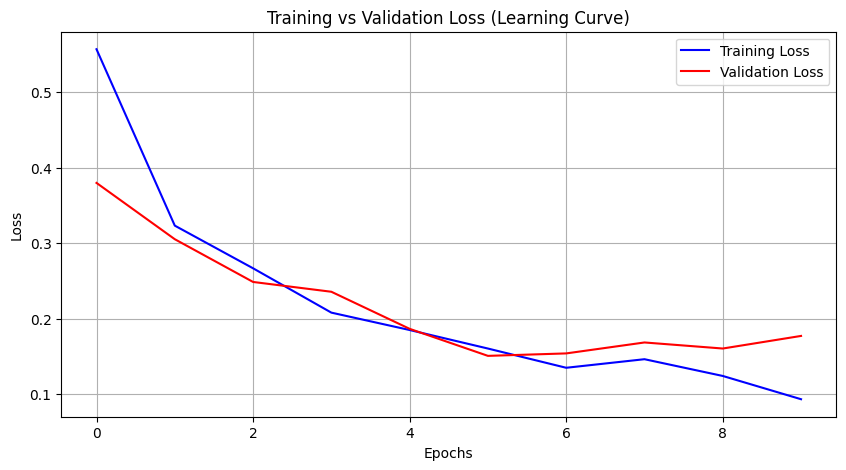

In [5]:
import matplotlib.pyplot as plt

# Lists to store metrics
train_losses = []
val_losses = []
best_val_loss = float('inf')

epochs = 10

for epoch in range(epochs):
    # --- TRAINING PHASE ---
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
    
    # Calculate average training loss for this epoch
    epoch_train_loss = running_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    # --- VALIDATION PHASE ---
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad(): # No gradients needed for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            
    # Calculate average validation loss for this epoch
    epoch_val_loss = running_val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

    # Check if this is the best model so far
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), 'best_fire_model.pth')
        print(f"--> Saved better model with val_loss: {best_val_loss:.4f}")
        

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.title('Training vs Validation Loss (Learning Curve)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
